# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "baseline_ptn_wisig",
    "lr": 0.001,
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 100,
    "num_examples_per_domain_per_label_target": 100,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float64",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "domains_source": [3],
    "domains_target": [1, 2, 4],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.07199795071703695
Average power, source: 0.006306497542264809


Average magnitude, target: 0.006358301294446141
Average power, target: 5.045497693681136e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 14], examples_per_second: 284.0435, train_label_loss: 3.5532, 


epoch: 1, [batch: 2 / 14], examples_per_second: 365.1316, train_label_loss: 3.3990, 


epoch: 1, [batch: 3 / 14], examples_per_second: 366.1072, train_label_loss: 3.1366, 


epoch: 1, [batch: 4 / 14], examples_per_second: 367.7977, train_label_loss: 2.8263, 


epoch: 1, [batch: 6 / 14], examples_per_second: 368.1828, train_label_loss: 2.8556, 


epoch: 1, [batch: 7 / 14], examples_per_second: 368.0989, train_label_loss: 2.8571, 


epoch: 1, [batch: 8 / 14], examples_per_second: 368.0024, train_label_loss: 2.5092, 


epoch: 1, [batch: 10 / 14], examples_per_second: 368.0747, train_label_loss: 2.4343, 


epoch: 1, [batch: 11 / 14], examples_per_second: 367.9568, train_label_loss: 2.1494, 


epoch: 1, [batch: 12 / 14], examples_per_second: 368.3505, train_label_loss: 2.0789, 


epoch: 1, source_val_acc_label: 0.6564, target_val_acc_label: 0.6248, source_val_label_loss: 3.7390, target_val_label_loss: 3.8076, 


New best


epoch: 2, [batch: 1 / 14], examples_per_second: 68.5412, train_label_loss: 3.5648, 


epoch: 2, [batch: 2 / 14], examples_per_second: 367.4039, train_label_loss: 3.3207, 


epoch: 2, [batch: 3 / 14], examples_per_second: 368.4898, train_label_loss: 2.9429, 


epoch: 2, [batch: 4 / 14], examples_per_second: 370.5852, train_label_loss: 2.7522, 


epoch: 2, [batch: 6 / 14], examples_per_second: 370.4861, train_label_loss: 2.2650, 


epoch: 2, [batch: 7 / 14], examples_per_second: 370.4447, train_label_loss: 2.1407, 


epoch: 2, [batch: 8 / 14], examples_per_second: 370.6158, train_label_loss: 2.0139, 


epoch: 2, [batch: 10 / 14], examples_per_second: 370.2178, train_label_loss: 1.8318, 


epoch: 2, [batch: 11 / 14], examples_per_second: 370.3845, train_label_loss: 1.7324, 


epoch: 2, [batch: 12 / 14], examples_per_second: 370.2648, train_label_loss: 2.2480, 


epoch: 2, source_val_acc_label: 0.6801, target_val_acc_label: 0.6556, source_val_label_loss: 1.9763, target_val_label_loss: 2.1228, 


New best


epoch: 3, [batch: 1 / 14], examples_per_second: 68.3548, train_label_loss: 1.7725, 


epoch: 3, [batch: 2 / 14], examples_per_second: 367.8810, train_label_loss: 2.0208, 


epoch: 3, [batch: 3 / 14], examples_per_second: 368.4070, train_label_loss: 2.1713, 


epoch: 3, [batch: 4 / 14], examples_per_second: 370.6702, train_label_loss: 1.6219, 


epoch: 3, [batch: 6 / 14], examples_per_second: 370.2114, train_label_loss: 1.7396, 


epoch: 3, [batch: 7 / 14], examples_per_second: 370.3139, train_label_loss: 1.7250, 


epoch: 3, [batch: 8 / 14], examples_per_second: 370.2991, train_label_loss: 1.3869, 


epoch: 3, [batch: 10 / 14], examples_per_second: 370.6177, train_label_loss: 1.7561, 


epoch: 3, [batch: 11 / 14], examples_per_second: 370.2248, train_label_loss: 1.4938, 


epoch: 3, [batch: 12 / 14], examples_per_second: 370.3685, train_label_loss: 1.2262, 


epoch: 3, source_val_acc_label: 0.7231, target_val_acc_label: 0.7004, source_val_label_loss: 1.4887, target_val_label_loss: 1.6907, 


New best


epoch: 4, [batch: 1 / 14], examples_per_second: 68.3038, train_label_loss: 1.4013, 


epoch: 4, [batch: 2 / 14], examples_per_second: 367.6242, train_label_loss: 1.5244, 


epoch: 4, [batch: 3 / 14], examples_per_second: 368.8391, train_label_loss: 1.4294, 


epoch: 4, [batch: 4 / 14], examples_per_second: 370.0832, train_label_loss: 1.3793, 


epoch: 4, [batch: 6 / 14], examples_per_second: 370.4725, train_label_loss: 1.2618, 


epoch: 4, [batch: 7 / 14], examples_per_second: 370.3784, train_label_loss: 1.2102, 


epoch: 4, [batch: 8 / 14], examples_per_second: 370.4115, train_label_loss: 1.3756, 


epoch: 4, [batch: 10 / 14], examples_per_second: 370.5136, train_label_loss: 1.2806, 


epoch: 4, [batch: 11 / 14], examples_per_second: 370.4285, train_label_loss: 1.4262, 


epoch: 4, [batch: 12 / 14], examples_per_second: 370.4576, train_label_loss: 1.3051, 


epoch: 4, source_val_acc_label: 0.7904, target_val_acc_label: 0.7415, source_val_label_loss: 1.2911, target_val_label_loss: 1.4862, 


New best


epoch: 5, [batch: 1 / 14], examples_per_second: 68.3070, train_label_loss: 1.0570, 


epoch: 5, [batch: 2 / 14], examples_per_second: 367.3082, train_label_loss: 1.2597, 


epoch: 5, [batch: 3 / 14], examples_per_second: 368.6339, train_label_loss: 1.2157, 


epoch: 5, [batch: 4 / 14], examples_per_second: 370.1173, train_label_loss: 1.5776, 


epoch: 5, [batch: 6 / 14], examples_per_second: 370.2347, train_label_loss: 1.2292, 


epoch: 5, [batch: 7 / 14], examples_per_second: 370.5204, train_label_loss: 1.2573, 


epoch: 5, [batch: 8 / 14], examples_per_second: 370.3448, train_label_loss: 1.5316, 


epoch: 5, [batch: 10 / 14], examples_per_second: 370.1655, train_label_loss: 1.1229, 


epoch: 5, [batch: 11 / 14], examples_per_second: 370.4476, train_label_loss: 1.0661, 


epoch: 5, [batch: 12 / 14], examples_per_second: 370.5520, train_label_loss: 1.0445, 


epoch: 5, source_val_acc_label: 0.8167, target_val_acc_label: 0.7682, source_val_label_loss: 1.1208, target_val_label_loss: 1.3236, 


New best


epoch: 6, [batch: 1 / 14], examples_per_second: 68.2888, train_label_loss: 1.0132, 


epoch: 6, [batch: 2 / 14], examples_per_second: 367.4274, train_label_loss: 0.9662, 


epoch: 6, [batch: 3 / 14], examples_per_second: 368.5722, train_label_loss: 0.9514, 


epoch: 6, [batch: 4 / 14], examples_per_second: 370.1005, train_label_loss: 1.0360, 


epoch: 6, [batch: 6 / 14], examples_per_second: 370.2902, train_label_loss: 0.9718, 


epoch: 6, [batch: 7 / 14], examples_per_second: 370.1959, train_label_loss: 0.9677, 


epoch: 6, [batch: 8 / 14], examples_per_second: 370.4407, train_label_loss: 1.1054, 


epoch: 6, [batch: 10 / 14], examples_per_second: 370.7256, train_label_loss: 1.3025, 


epoch: 6, [batch: 11 / 14], examples_per_second: 370.2574, train_label_loss: 1.1307, 


epoch: 6, [batch: 12 / 14], examples_per_second: 370.3958, train_label_loss: 0.7397, 


epoch: 6, source_val_acc_label: 0.8397, target_val_acc_label: 0.7891, source_val_label_loss: 0.9555, target_val_label_loss: 1.1869, 


New best


epoch: 7, [batch: 1 / 14], examples_per_second: 68.2074, train_label_loss: 0.9570, 


epoch: 7, [batch: 2 / 14], examples_per_second: 367.5318, train_label_loss: 0.8165, 


epoch: 7, [batch: 3 / 14], examples_per_second: 368.5653, train_label_loss: 0.8839, 


epoch: 7, [batch: 4 / 14], examples_per_second: 370.3388, train_label_loss: 0.8381, 


epoch: 7, [batch: 6 / 14], examples_per_second: 370.4222, train_label_loss: 0.7797, 


epoch: 7, [batch: 7 / 14], examples_per_second: 370.4145, train_label_loss: 0.8452, 


epoch: 7, [batch: 8 / 14], examples_per_second: 370.1669, train_label_loss: 0.7688, 


epoch: 7, [batch: 10 / 14], examples_per_second: 370.2996, train_label_loss: 0.8329, 


epoch: 7, [batch: 11 / 14], examples_per_second: 370.3295, train_label_loss: 0.8241, 


epoch: 7, [batch: 12 / 14], examples_per_second: 370.1723, train_label_loss: 0.7594, 


epoch: 7, source_val_acc_label: 0.8526, target_val_acc_label: 0.8047, source_val_label_loss: 0.8831, target_val_label_loss: 1.1509, 


New best


epoch: 8, [batch: 1 / 14], examples_per_second: 68.2263, train_label_loss: 0.7500, 


epoch: 8, [batch: 2 / 14], examples_per_second: 367.2728, train_label_loss: 0.8291, 


epoch: 8, [batch: 3 / 14], examples_per_second: 368.3491, train_label_loss: 0.7666, 


epoch: 8, [batch: 4 / 14], examples_per_second: 370.6540, train_label_loss: 0.8516, 


epoch: 8, [batch: 6 / 14], examples_per_second: 370.3775, train_label_loss: 0.9019, 


epoch: 8, [batch: 7 / 14], examples_per_second: 370.4058, train_label_loss: 0.8001, 


epoch: 8, [batch: 8 / 14], examples_per_second: 369.9569, train_label_loss: 0.8482, 


epoch: 8, [batch: 10 / 14], examples_per_second: 370.3194, train_label_loss: 0.7543, 


epoch: 8, [batch: 11 / 14], examples_per_second: 370.1790, train_label_loss: 0.8413, 


epoch: 8, [batch: 12 / 14], examples_per_second: 370.2145, train_label_loss: 0.8192, 


epoch: 8, source_val_acc_label: 0.8603, target_val_acc_label: 0.8028, source_val_label_loss: 0.8405, target_val_label_loss: 1.0586, 


New best


epoch: 9, [batch: 1 / 14], examples_per_second: 68.2586, train_label_loss: 0.7106, 


epoch: 9, [batch: 2 / 14], examples_per_second: 366.9604, train_label_loss: 0.6193, 


epoch: 9, [batch: 3 / 14], examples_per_second: 368.2679, train_label_loss: 0.9098, 


epoch: 9, [batch: 4 / 14], examples_per_second: 370.5027, train_label_loss: 0.7318, 


epoch: 9, [batch: 6 / 14], examples_per_second: 370.5167, train_label_loss: 0.6842, 


epoch: 9, [batch: 7 / 14], examples_per_second: 370.2507, train_label_loss: 0.8425, 


epoch: 9, [batch: 8 / 14], examples_per_second: 370.1660, train_label_loss: 0.6203, 


epoch: 9, [batch: 10 / 14], examples_per_second: 370.2853, train_label_loss: 0.7254, 


epoch: 9, [batch: 11 / 14], examples_per_second: 370.2410, train_label_loss: 0.6406, 


epoch: 9, [batch: 12 / 14], examples_per_second: 370.2579, train_label_loss: 0.8053, 


epoch: 9, source_val_acc_label: 0.8641, target_val_acc_label: 0.8064, source_val_label_loss: 0.8025, target_val_label_loss: 1.0529, 


New best


epoch: 10, [batch: 1 / 14], examples_per_second: 68.2636, train_label_loss: 0.6537, 


epoch: 10, [batch: 2 / 14], examples_per_second: 367.6100, train_label_loss: 0.6217, 


epoch: 10, [batch: 3 / 14], examples_per_second: 368.8915, train_label_loss: 0.5578, 


epoch: 10, [batch: 4 / 14], examples_per_second: 370.2400, train_label_loss: 1.3248, 


epoch: 10, [batch: 6 / 14], examples_per_second: 370.3516, train_label_loss: 0.6395, 


epoch: 10, [batch: 7 / 14], examples_per_second: 370.4302, train_label_loss: 0.5900, 


epoch: 10, [batch: 8 / 14], examples_per_second: 370.4416, train_label_loss: 0.4894, 


epoch: 10, [batch: 10 / 14], examples_per_second: 370.1851, train_label_loss: 0.7073, 


epoch: 10, [batch: 11 / 14], examples_per_second: 370.2809, train_label_loss: 0.5153, 


epoch: 10, [batch: 12 / 14], examples_per_second: 370.0991, train_label_loss: 0.7379, 


epoch: 10, source_val_acc_label: 0.8776, target_val_acc_label: 0.8218, source_val_label_loss: 0.7245, target_val_label_loss: 0.9936, 


New best


epoch: 11, [batch: 1 / 14], examples_per_second: 68.2782, train_label_loss: 0.6143, 


epoch: 11, [batch: 2 / 14], examples_per_second: 367.4422, train_label_loss: 0.5865, 


epoch: 11, [batch: 3 / 14], examples_per_second: 368.7891, train_label_loss: 0.6832, 


epoch: 11, [batch: 4 / 14], examples_per_second: 370.3449, train_label_loss: 0.5611, 


epoch: 11, [batch: 6 / 14], examples_per_second: 370.4767, train_label_loss: 0.6387, 


epoch: 11, [batch: 7 / 14], examples_per_second: 370.6325, train_label_loss: 0.7934, 


epoch: 11, [batch: 8 / 14], examples_per_second: 370.6486, train_label_loss: 0.5663, 


epoch: 11, [batch: 10 / 14], examples_per_second: 370.3759, train_label_loss: 0.6856, 


epoch: 11, [batch: 11 / 14], examples_per_second: 370.5490, train_label_loss: 0.7296, 


epoch: 11, [batch: 12 / 14], examples_per_second: 370.3457, train_label_loss: 0.5299, 


epoch: 11, source_val_acc_label: 0.8814, target_val_acc_label: 0.8190, source_val_label_loss: 0.6851, target_val_label_loss: 0.9633, 


New best


epoch: 12, [batch: 1 / 14], examples_per_second: 68.2757, train_label_loss: 0.7839, 


epoch: 12, [batch: 2 / 14], examples_per_second: 367.4027, train_label_loss: 0.5127, 


epoch: 12, [batch: 3 / 14], examples_per_second: 368.3953, train_label_loss: 0.4452, 


epoch: 12, [batch: 4 / 14], examples_per_second: 370.2139, train_label_loss: 0.6004, 


epoch: 12, [batch: 6 / 14], examples_per_second: 370.3273, train_label_loss: 0.5162, 


epoch: 12, [batch: 7 / 14], examples_per_second: 370.4162, train_label_loss: 0.6472, 


epoch: 12, [batch: 8 / 14], examples_per_second: 370.1690, train_label_loss: 0.5204, 


epoch: 12, [batch: 10 / 14], examples_per_second: 370.4700, train_label_loss: 0.5405, 


epoch: 12, [batch: 11 / 14], examples_per_second: 370.1560, train_label_loss: 0.5986, 


epoch: 12, [batch: 12 / 14], examples_per_second: 370.3744, train_label_loss: 0.4522, 


epoch: 12, source_val_acc_label: 0.8853, target_val_acc_label: 0.8259, source_val_label_loss: 0.6618, target_val_label_loss: 0.9614, 


New best


epoch: 13, [batch: 1 / 14], examples_per_second: 68.2458, train_label_loss: 0.5861, 


epoch: 13, [batch: 2 / 14], examples_per_second: 367.5403, train_label_loss: 0.6808, 


epoch: 13, [batch: 3 / 14], examples_per_second: 368.5254, train_label_loss: 0.5149, 


epoch: 13, [batch: 4 / 14], examples_per_second: 370.2467, train_label_loss: 0.4728, 


epoch: 13, [batch: 6 / 14], examples_per_second: 370.2728, train_label_loss: 0.5411, 


epoch: 13, [batch: 7 / 14], examples_per_second: 370.1705, train_label_loss: 0.3865, 


epoch: 13, [batch: 8 / 14], examples_per_second: 370.6703, train_label_loss: 0.5839, 


epoch: 13, [batch: 10 / 14], examples_per_second: 370.2542, train_label_loss: 0.3134, 


epoch: 13, [batch: 11 / 14], examples_per_second: 370.2061, train_label_loss: 0.5776, 


epoch: 13, [batch: 12 / 14], examples_per_second: 370.3726, train_label_loss: 0.5874, 


epoch: 13, source_val_acc_label: 0.8917, target_val_acc_label: 0.8327, source_val_label_loss: 0.6381, target_val_label_loss: 0.9471, 


New best


epoch: 14, [batch: 1 / 14], examples_per_second: 68.2238, train_label_loss: 0.5344, 


epoch: 14, [batch: 2 / 14], examples_per_second: 367.3013, train_label_loss: 0.6934, 


epoch: 14, [batch: 3 / 14], examples_per_second: 367.7409, train_label_loss: 0.4486, 


epoch: 14, [batch: 4 / 14], examples_per_second: 370.1204, train_label_loss: 0.6005, 


epoch: 14, [batch: 6 / 14], examples_per_second: 370.3816, train_label_loss: 0.7378, 


epoch: 14, [batch: 7 / 14], examples_per_second: 369.9533, train_label_loss: 0.4585, 


epoch: 14, [batch: 8 / 14], examples_per_second: 370.2804, train_label_loss: 0.4824, 


epoch: 14, [batch: 10 / 14], examples_per_second: 370.3294, train_label_loss: 0.5775, 


epoch: 14, [batch: 11 / 14], examples_per_second: 370.1230, train_label_loss: 0.4236, 


epoch: 14, [batch: 12 / 14], examples_per_second: 370.1647, train_label_loss: 0.4852, 


epoch: 14, source_val_acc_label: 0.8994, target_val_acc_label: 0.8312, source_val_label_loss: 0.5987, target_val_label_loss: 0.9074, 


New best


epoch: 15, [batch: 1 / 14], examples_per_second: 68.0143, train_label_loss: 0.6759, 


epoch: 15, [batch: 2 / 14], examples_per_second: 367.2644, train_label_loss: 0.4140, 


epoch: 15, [batch: 3 / 14], examples_per_second: 368.2267, train_label_loss: 0.3303, 


epoch: 15, [batch: 4 / 14], examples_per_second: 370.3651, train_label_loss: 0.5011, 


epoch: 15, [batch: 6 / 14], examples_per_second: 370.3409, train_label_loss: 0.3530, 


epoch: 15, [batch: 7 / 14], examples_per_second: 370.2949, train_label_loss: 0.4214, 


epoch: 15, [batch: 8 / 14], examples_per_second: 370.4097, train_label_loss: 0.6128, 


epoch: 15, [batch: 10 / 14], examples_per_second: 370.4698, train_label_loss: 0.5797, 


epoch: 15, [batch: 11 / 14], examples_per_second: 370.1891, train_label_loss: 0.4116, 


epoch: 15, [batch: 12 / 14], examples_per_second: 370.1929, train_label_loss: 0.5100, 


epoch: 15, source_val_acc_label: 0.9045, target_val_acc_label: 0.8368, source_val_label_loss: 0.6085, target_val_label_loss: 0.8971, 


New best


epoch: 16, [batch: 1 / 14], examples_per_second: 68.1962, train_label_loss: 0.5669, 


epoch: 16, [batch: 2 / 14], examples_per_second: 367.3124, train_label_loss: 0.6372, 


epoch: 16, [batch: 3 / 14], examples_per_second: 368.5785, train_label_loss: 0.4327, 


epoch: 16, [batch: 4 / 14], examples_per_second: 370.4280, train_label_loss: 0.5164, 


epoch: 16, [batch: 6 / 14], examples_per_second: 370.4310, train_label_loss: 0.5054, 


epoch: 16, [batch: 7 / 14], examples_per_second: 370.4133, train_label_loss: 0.6659, 


epoch: 16, [batch: 8 / 14], examples_per_second: 370.6278, train_label_loss: 0.5793, 


epoch: 16, [batch: 10 / 14], examples_per_second: 370.6345, train_label_loss: 0.5797, 


epoch: 16, [batch: 11 / 14], examples_per_second: 370.3208, train_label_loss: 0.4325, 


epoch: 16, [batch: 12 / 14], examples_per_second: 370.5900, train_label_loss: 0.4767, 


epoch: 16, source_val_acc_label: 0.9026, target_val_acc_label: 0.8408, source_val_label_loss: 0.5842, target_val_label_loss: 0.8608, 


New best


epoch: 17, [batch: 1 / 14], examples_per_second: 68.2693, train_label_loss: 0.4266, 


epoch: 17, [batch: 2 / 14], examples_per_second: 367.6891, train_label_loss: 0.5021, 


epoch: 17, [batch: 3 / 14], examples_per_second: 368.4884, train_label_loss: 0.4293, 


epoch: 17, [batch: 4 / 14], examples_per_second: 370.2514, train_label_loss: 0.4411, 


epoch: 17, [batch: 6 / 14], examples_per_second: 370.5067, train_label_loss: 0.3280, 


epoch: 17, [batch: 7 / 14], examples_per_second: 370.3024, train_label_loss: 0.2828, 


epoch: 17, [batch: 8 / 14], examples_per_second: 370.3084, train_label_loss: 0.7520, 


epoch: 17, [batch: 10 / 14], examples_per_second: 370.0915, train_label_loss: 0.4192, 


epoch: 17, [batch: 11 / 14], examples_per_second: 370.3360, train_label_loss: 0.3085, 


epoch: 17, [batch: 12 / 14], examples_per_second: 370.5211, train_label_loss: 0.5366, 


epoch: 17, source_val_acc_label: 0.9090, target_val_acc_label: 0.8415, source_val_label_loss: 0.5461, target_val_label_loss: 0.8478, 


New best


epoch: 18, [batch: 1 / 14], examples_per_second: 68.3121, train_label_loss: 0.3286, 


epoch: 18, [batch: 2 / 14], examples_per_second: 367.2785, train_label_loss: 0.4314, 


epoch: 18, [batch: 3 / 14], examples_per_second: 368.5248, train_label_loss: 0.3696, 


epoch: 18, [batch: 4 / 14], examples_per_second: 370.6515, train_label_loss: 0.4396, 


epoch: 18, [batch: 6 / 14], examples_per_second: 370.3533, train_label_loss: 0.3973, 


epoch: 18, [batch: 7 / 14], examples_per_second: 370.0228, train_label_loss: 0.6510, 


epoch: 18, [batch: 8 / 14], examples_per_second: 370.2942, train_label_loss: 0.3030, 


epoch: 18, [batch: 10 / 14], examples_per_second: 370.3708, train_label_loss: 0.4093, 


epoch: 18, [batch: 11 / 14], examples_per_second: 370.1587, train_label_loss: 0.4783, 


epoch: 18, [batch: 12 / 14], examples_per_second: 370.4043, train_label_loss: 0.4476, 


epoch: 18, source_val_acc_label: 0.9045, target_val_acc_label: 0.8423, source_val_label_loss: 0.5755, target_val_label_loss: 0.8513, 


epoch: 19, [batch: 1 / 14], examples_per_second: 68.7285, train_label_loss: 0.4940, 


epoch: 19, [batch: 2 / 14], examples_per_second: 367.5327, train_label_loss: 0.4475, 


epoch: 19, [batch: 3 / 14], examples_per_second: 368.8304, train_label_loss: 0.3910, 


epoch: 19, [batch: 4 / 14], examples_per_second: 370.3624, train_label_loss: 0.4119, 


epoch: 19, [batch: 6 / 14], examples_per_second: 370.2850, train_label_loss: 0.4320, 


epoch: 19, [batch: 7 / 14], examples_per_second: 370.5038, train_label_loss: 0.4334, 


epoch: 19, [batch: 8 / 14], examples_per_second: 370.1641, train_label_loss: 0.2867, 


epoch: 19, [batch: 10 / 14], examples_per_second: 370.5291, train_label_loss: 0.3137, 


epoch: 19, [batch: 11 / 14], examples_per_second: 370.3233, train_label_loss: 0.5151, 


epoch: 19, [batch: 12 / 14], examples_per_second: 370.2956, train_label_loss: 0.3223, 


epoch: 19, source_val_acc_label: 0.9109, target_val_acc_label: 0.8470, source_val_label_loss: 0.5408, target_val_label_loss: 0.8197, 


New best


epoch: 20, [batch: 1 / 14], examples_per_second: 68.2504, train_label_loss: 0.3715, 


epoch: 20, [batch: 2 / 14], examples_per_second: 367.9982, train_label_loss: 0.4133, 


epoch: 20, [batch: 3 / 14], examples_per_second: 368.5011, train_label_loss: 0.4404, 


epoch: 20, [batch: 4 / 14], examples_per_second: 370.0418, train_label_loss: 0.5275, 


epoch: 20, [batch: 6 / 14], examples_per_second: 370.5442, train_label_loss: 0.4062, 


epoch: 20, [batch: 7 / 14], examples_per_second: 370.0868, train_label_loss: 0.3687, 


epoch: 20, [batch: 8 / 14], examples_per_second: 370.5875, train_label_loss: 0.5773, 


epoch: 20, [batch: 10 / 14], examples_per_second: 370.5783, train_label_loss: 0.3139, 


epoch: 20, [batch: 11 / 14], examples_per_second: 370.3637, train_label_loss: 0.5900, 


epoch: 20, [batch: 12 / 14], examples_per_second: 370.0354, train_label_loss: 0.3966, 


epoch: 20, source_val_acc_label: 0.9006, target_val_acc_label: 0.8359, source_val_label_loss: 0.5782, target_val_label_loss: 0.8995, 


epoch: 21, [batch: 1 / 14], examples_per_second: 68.7862, train_label_loss: 0.3709, 


epoch: 21, [batch: 2 / 14], examples_per_second: 367.6777, train_label_loss: 0.5871, 


epoch: 21, [batch: 3 / 14], examples_per_second: 368.6960, train_label_loss: 0.2930, 


epoch: 21, [batch: 4 / 14], examples_per_second: 370.4552, train_label_loss: 0.4725, 


epoch: 21, [batch: 6 / 14], examples_per_second: 370.5232, train_label_loss: 0.4882, 


epoch: 21, [batch: 7 / 14], examples_per_second: 370.5000, train_label_loss: 0.5756, 


epoch: 21, [batch: 8 / 14], examples_per_second: 370.4670, train_label_loss: 0.3351, 


epoch: 21, [batch: 10 / 14], examples_per_second: 370.5289, train_label_loss: 0.4474, 


epoch: 21, [batch: 11 / 14], examples_per_second: 370.4797, train_label_loss: 0.4471, 


epoch: 21, [batch: 12 / 14], examples_per_second: 370.5415, train_label_loss: 0.3938, 


epoch: 21, source_val_acc_label: 0.9032, target_val_acc_label: 0.8365, source_val_label_loss: 0.5593, target_val_label_loss: 0.8556, 


epoch: 22, [batch: 1 / 14], examples_per_second: 68.7202, train_label_loss: 0.3668, 


epoch: 22, [batch: 2 / 14], examples_per_second: 367.2975, train_label_loss: 0.4587, 


epoch: 22, [batch: 3 / 14], examples_per_second: 368.8514, train_label_loss: 0.4337, 


epoch: 22, [batch: 4 / 14], examples_per_second: 370.3202, train_label_loss: 0.4693, 


epoch: 22, [batch: 6 / 14], examples_per_second: 370.4919, train_label_loss: 0.4068, 


epoch: 22, [batch: 7 / 14], examples_per_second: 370.5940, train_label_loss: 0.4146, 


epoch: 22, [batch: 8 / 14], examples_per_second: 370.4959, train_label_loss: 0.4823, 


epoch: 22, [batch: 10 / 14], examples_per_second: 370.5851, train_label_loss: 0.5255, 


epoch: 22, [batch: 11 / 14], examples_per_second: 370.4682, train_label_loss: 0.3184, 


epoch: 22, [batch: 12 / 14], examples_per_second: 370.5358, train_label_loss: 0.5299, 


epoch: 22, source_val_acc_label: 0.9096, target_val_acc_label: 0.8436, source_val_label_loss: 0.5429, target_val_label_loss: 0.8740, 


epoch: 23, [batch: 1 / 14], examples_per_second: 68.7644, train_label_loss: 0.4570, 


epoch: 23, [batch: 2 / 14], examples_per_second: 367.3593, train_label_loss: 0.4421, 


epoch: 23, [batch: 3 / 14], examples_per_second: 368.5031, train_label_loss: 0.4342, 


epoch: 23, [batch: 4 / 14], examples_per_second: 370.5131, train_label_loss: 0.5099, 


epoch: 23, [batch: 6 / 14], examples_per_second: 370.3582, train_label_loss: 0.3574, 


epoch: 23, [batch: 7 / 14], examples_per_second: 370.3507, train_label_loss: 0.4231, 


epoch: 23, [batch: 8 / 14], examples_per_second: 370.1602, train_label_loss: 0.2511, 


epoch: 23, [batch: 10 / 14], examples_per_second: 370.4563, train_label_loss: 0.4130, 


epoch: 23, [batch: 11 / 14], examples_per_second: 370.5004, train_label_loss: 0.3359, 


epoch: 23, [batch: 12 / 14], examples_per_second: 370.5525, train_label_loss: 0.2722, 


epoch: 23, source_val_acc_label: 0.9141, target_val_acc_label: 0.8455, source_val_label_loss: 0.5295, target_val_label_loss: 0.8465, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

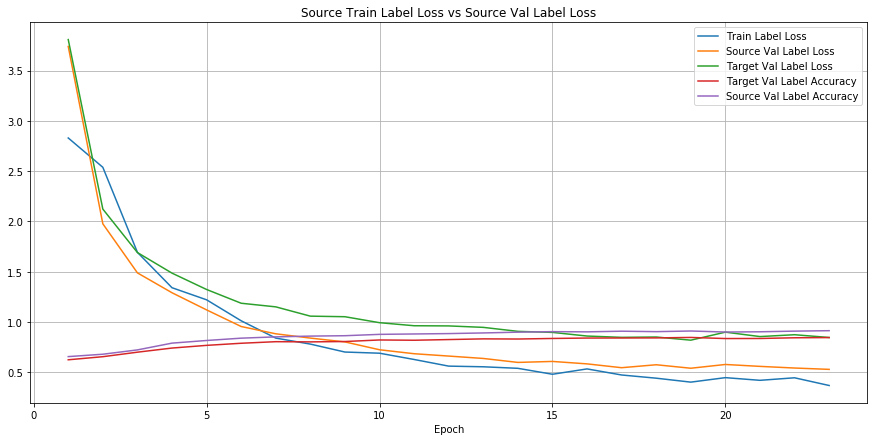

In [16]:
ax = get_loss_curve(experiment)
plt.show()

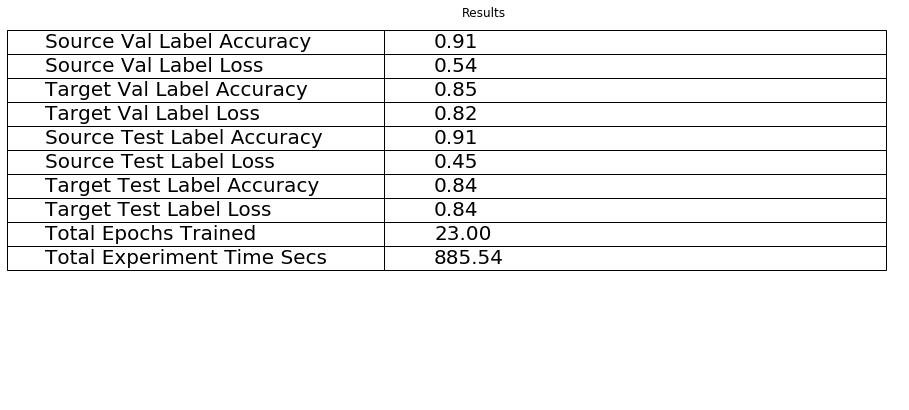

In [17]:
get_results_table(experiment)

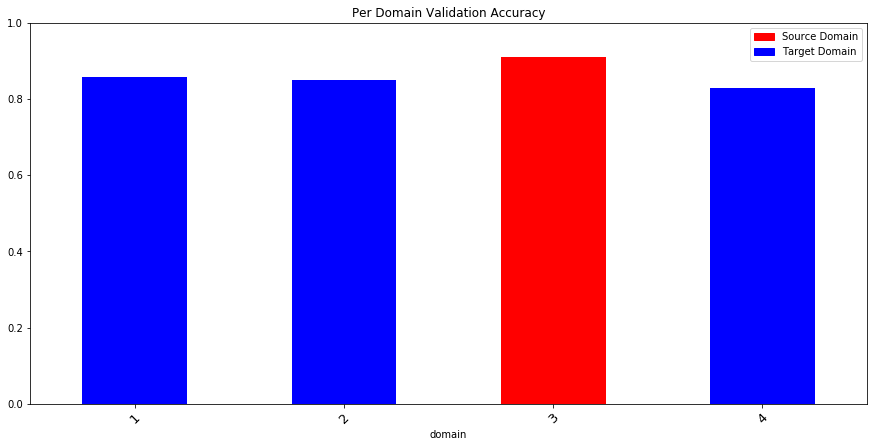

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9141025641025641 Target Test Label Accuracy: 0.8427350427350427
Source Val Label Accuracy: 0.9108974358974359 Target Val Label Accuracy: 0.847008547008547


In [20]:
json.dumps(experiment)

'{"experiment_name": "baseline_ptn_wisig", "parameters": {"experiment_name": "baseline_ptn_wisig", "lr": 0.001, "device": "cuda", "seed": 1337, "dataset_seed": 1337, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4",